In [2]:
# Load all the libraries required

import os
import cv2
import sys
import time
import glob
import shutil
import pickle
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import tqdm.notebook as tq
from tqdm import trange
import matplotlib.pyplot as plt
from torch.nn.utils import clip_grad_value_
from sklearn.model_selection import train_test_split
torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
# Implementation of ConvLSTM Cell and Layer taken from
# https://github.com/KimUyen/ConvLSTM-Pytorch

class HadamardProduct(nn.Module):
    def __init__(self, shape):
        super(HadamardProduct, self).__init__()
        self.weights = nn.Parameter(torch.rand(shape)).cuda()
        
    def forward(self, x):
        return x*self.weights

class ConvLSTMCell(nn.Module):

    def __init__(self, img_size, input_dim, hidden_dim, kernel_size, 
                 cnn_dropout, rnn_dropout, bias=True, peephole=False,
                 layer_norm=False):
        """
        Initialize ConvLSTM cell.
        Parameters
        ----------
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel for both cnn and rnn.
        cnn_dropout, rnn_dropout: float
            cnn_dropout: dropout rate for convolutional input.
            rnn_dropout: dropout rate for convolutional state.
        bias: bool
            Whether or not to add the bias.
        peephole: bool
            add connection between cell state to gates
        layer_norm: bool
            layer normalization 
        """

        super(ConvLSTMCell, self).__init__()
        self.input_shape = img_size
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.padding = (int(self.kernel_size[0]/2), int(self.kernel_size[1]/2))
        self.stride = (1, 1)
        self.bias = bias
        self.peephole = peephole
        self.layer_norm = layer_norm
        
        self.out_height = int((self.input_shape[0] - self.kernel_size[0] + 2*self.padding[0])/self.stride[0] + 1)
        self.out_width = int((self.input_shape[1] - self.kernel_size[1] + 2*self.padding[1])/self.stride[1] + 1)
        
        self.input_conv = nn.Conv2d(in_channels=self.input_dim, out_channels=4*self.hidden_dim,
                                  kernel_size=self.kernel_size,
                                  stride = self.stride,
                                  padding=self.padding,
                                  bias=self.bias)
        self.rnn_conv = nn.Conv2d(self.hidden_dim, out_channels=4*self.hidden_dim, 
                                  kernel_size = self.kernel_size,
                                  padding=(math.floor(self.kernel_size[0]/2), 
                                         math.floor(self.kernel_size[1]/2)),
                                  bias=self.bias)
        
        if self.peephole is True:
            self.weight_ci = HadamardProduct((1, self.hidden_dim, self.out_height, self.out_width))
            self.weight_cf = HadamardProduct((1, self.hidden_dim, self.out_height, self.out_width))
            self.weight_co = HadamardProduct((1, self.hidden_dim, self.out_height, self.out_width))
            self.layer_norm_ci = nn.LayerNorm([self.hidden_dim, self.out_height, self.out_width])
            self.layer_norm_cf = nn.LayerNorm([self.hidden_dim, self.out_height, self.out_width])
            self.layer_norm_co = nn.LayerNorm([self.hidden_dim, self.out_height, self.out_width])
        
            
        self.cnn_dropout = nn.Dropout(cnn_dropout)
        self.rnn_dropout = nn.Dropout(rnn_dropout)
        
        self.layer_norm_x = nn.LayerNorm([4*self.hidden_dim, self.out_height, self.out_width])
        self.layer_norm_h = nn.LayerNorm([4*self.hidden_dim, self.out_height, self.out_width])
        self.layer_norm_cnext = nn.LayerNorm([self.hidden_dim, self.out_height, self.out_width])
    
    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        x = self.cnn_dropout(input_tensor)
        x_conv = self.input_conv(x)
        if self.layer_norm is True:
            x_conv = self.layer_norm_x(x_conv)
        # separate i, f, c o
        x_i, x_f, x_c, x_o = torch.split(x_conv, self.hidden_dim, dim=1)
        
        h = self.rnn_dropout(h_cur)
        h_conv = self.rnn_conv(h)
        if self.layer_norm is True:
            h_conv = self.layer_norm_h(h_conv)
        # separate i, f, c o
        h_i, h_f, h_c, h_o = torch.split(h_conv, self.hidden_dim, dim=1)
        

        if self.peephole is True:
            f = torch.sigmoid((x_f + h_f) +  self.layer_norm_cf(self.weight_cf(c_cur)) if self.layer_norm is True else self.weight_cf(c_cur))
            i = torch.sigmoid((x_i + h_i) +  self.layer_norm_ci(self.weight_ci(c_cur)) if self.layer_norm is True else self.weight_ci(c_cur))
        else:
            f = torch.sigmoid((x_f + h_f))
            i = torch.sigmoid((x_i + h_i))
        
        
        g = torch.tanh((x_c + h_c))
        c_next = f * c_cur + i * g
        if self.peephole is True:
            o = torch.sigmoid(x_o + h_o + self.layer_norm_co(self.weight_co(c_cur)) if self.layer_norm is True else self.weight_co(c_cur))
        else:
            o = torch.sigmoid((x_o + h_o))
        
        if self.layer_norm is True:
            c_next = self.layer_norm_cnext(c_next)
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size):
        height, width = self.out_height, self.out_width
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.input_conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.input_conv.weight.device))


class ConvLSTM(nn.Module):

    """
    Parameters:
        input_dim: Number of channels in input
        hidden_dim: Number of hidden channels
        kernel_size: Size of kernel in convolutions
        cnn_dropout, rnn_dropout: float
            cnn_dropout: dropout rate for convolutional input.
            rnn_dropout: dropout rate for convolutional state.
        batch_first: Whether or not dimension 0 is the batch or not
        bias: Bias or no bias in Convolution
        return_sequence: return output sequence or final output only
        bidirectional: bool
            bidirectional ConvLSTM
    Input:
        A tensor of size B, T, C, H, W or T, B, C, H, W
    Output:
        A tuple of two sequences output and state
    Example:
        >> x = torch.rand((32, 10, 64, 128, 128))
        >> convlstm = ConvLSTM(input_dim=64, hidden_dim=16, kernel_size=(3, 3), 
                               cnn_dropout = 0.2,
                               rnn_dropout=0.2, batch_first=True, bias=False)
        >> output, last_state = convlstm(x)
    """

    def __init__(self, img_size, input_dim, hidden_dim, kernel_size,
                 cnn_dropout=0.5, rnn_dropout=0.5,  
                 batch_first=False, bias=True, peephole=False,
                 layer_norm=False,
                 return_sequence=True,
                 bidirectional=False):
        super(ConvLSTM, self).__init__()

        print(kernel_size)
        self.batch_first = batch_first
        self.return_sequence = return_sequence
        self.bidirectional = bidirectional

        cell_fw = ConvLSTMCell(img_size = img_size,
                                 input_dim=input_dim,
                                 hidden_dim=hidden_dim,
                                 kernel_size=kernel_size,
                                 cnn_dropout=cnn_dropout,
                                 rnn_dropout=rnn_dropout,
                                 bias=bias,
                                 peephole=peephole,
                                 layer_norm=layer_norm)
        self.cell_fw = cell_fw
        
        if self.bidirectional is True:
            cell_bw = ConvLSTMCell(img_size = img_size,
                                     input_dim=input_dim,
                                     hidden_dim=hidden_dim,
                                     kernel_size=kernel_size,
                                     cnn_dropout=cnn_dropout,
                                     rnn_dropout=rnn_dropout,
                                     bias=bias,
                                     peephole=peephole,
                                     layer_norm=layer_norm)
            self.cell_bw = cell_bw

    def forward(self, input_tensor, hidden_state=None):
        """
        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful
        Returns
        -------
        layer_output, last_state
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        b, seq_len, _, h, w = input_tensor.size()

        # Implement stateful ConvLSTM
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            # Since the init is done in forward. Can send image size here
            hidden_state, hidden_state_inv = self._init_hidden(batch_size=b)
            # if self.bidirectional is True:
            #     hidden_state_inv = self._init_hidden(batch_size=b)

        ## LSTM forward direction
        input_fw = input_tensor
        h, c = hidden_state
        output_inner = []
        for t in range(seq_len):
            h, c = self.cell_fw(input_tensor=input_fw[:, t, :, :, :],
                                             cur_state=[h, c])
            
            output_inner.append(h)
        output_inner = torch.stack((output_inner), dim=1)
        layer_output = output_inner
        last_state = [h, c]
        ####################
        
        
        ## LSTM inverse direction
        if self.bidirectional is True:
            input_inv = input_tensor
            h_inv, c_inv = hidden_state_inv
            output_inv = []
            for t in range(seq_len-1, -1, -1):
                h_inv, c_inv = self.cell_bw(input_tensor=input_inv[:, t, :, :, :],
                                                 cur_state=[h_inv, c_inv])
                
                output_inv.append(h_inv)
            output_inv.reverse() 
            output_inv = torch.stack((output_inv), dim=1)
            layer_output = torch.cat((output_inner, output_inv), dim=2)
            last_state_inv = [h_inv, c_inv]
        ###################################
        
        return layer_output if self.return_sequence is True else layer_output[:, -1:] if self.bidirectional is True else None

    def _init_hidden(self, batch_size):
        init_states_fw = self.cell_fw.init_hidden(batch_size)
        init_states_bw = None
        if self.bidirectional is True:
            init_states_bw = self.cell_bw.init_hidden(batch_size)
        return init_states_fw, init_states_bw

In [6]:
# Functions and Modules, utilities and DataLoaders
# DataLoader is for loading training dataset
# Testloader is used for loading test files, while predicting or denoising individual files

def printDiagram(model, data, location):
    import hiddenlayer as hl
    transforms = [ hl.transforms.Prune('Constant') ] # Removes Constant nodes from graph.
    graph = hl.build_graph(model, data, transforms=transforms)
    graph.theme = hl.graph.THEMES['blue'].copy()
    graph.save(location, format='png')

def updateColor(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def reformatTensor2Image(tensor):
     return torch.permute(tensor, (1, 2, 0)).cpu().detach().numpy()

class DataLoader():
    def __init__(self, device):
        self.device = device
        self.cacheX = []
        self.cacheY = []
        self.cacheInfo = ''
        
    def loadVideo(self, dataDirectory, dataInfo, cached=0):
        if cached==1:
            with open('x.pickle', 'rb') as fp:
                self.cacheX = pickle.load(fp)
            with open('y.pickle', 'rb') as fp:
                self.cacheY = pickle.load(fp)
        else:
            for i in tq.tqdm( dataInfo.index ) :
                if dataInfo['frames'][i] == 100:
                    location = dataDirectory + dataInfo['dirname'][i]
                    cacheX, cacheY = [], []
                    inPath = glob.glob( location + '/input/*.jpg' )
                    outPath = glob.glob( location + '/GT/*.jpg' )

                    for img in (inPath):
                        cacheX.append( updateColor( cv2.resize( cv2.imread(img), (640, 360) ) ) )
                    for img in (outPath):
                        cacheY.append( updateColor( cv2.resize( cv2.imread(img), (640, 360) ) ) )
                    self.cacheX.append(cacheX)
                    self.cacheY.append(cacheY)
        
    def loadUnit(self, index, offset):
        
        extraUnits = 2
        lb = max(0, offset - extraUnits)
        rb = min(offset + extraUnits, len(self.cacheX[index]) - 1)
        padleft = max(0, extraUnits - offset)
        padright = max(0, extraUnits - (len(self.cacheX[index])-1 - offset))
        
        #print(lb, rb, padleft, padright, len(self.cacheX[index]))
        X = [self.cacheX[index][lb]] * padleft + self.cacheX[index][lb: rb+1] + [self.cacheX[index][rb]] * padright
        Y = self.cacheY[index][offset] 
        
        return X, Y
    
    def loadBatch(self, xrange, offset, modelType='stackConv'):
        X, Y = [], []
        for i in range(xrange[0], xrange[1]):
            tempX, tempY = self.loadUnit(i, offset)
            X.append(tempX)
            Y.append(tempY)
        X, Y = np.array(X).astype('float32')/255, np.array(Y).astype('float32')/255
        tensorX, tensorY = torch.tensor(X).to(device), torch.tensor(Y).to(device)
        if modelType == 'stackConv':
            tensorX, tensorY = tensorX.permute( (0, 4, 1, 2, 3)), tensorY.permute( (0, 3, 1, 2) )
        elif modelType == 'convLSTM':
            tensorX, tensorY = tensorX.permute( (0, 1, 4, 2, 3)), tensorY.permute( (0, 3, 1, 2) )
        return tensorX, tensorY

class TestLoader():
    def __init__(self, location, device):
        self.device = device
        self.cacheX = []
        self.counter = 0
        self.cacheInfo = ''
        inPath = glob.glob( location + '/*.jpg' )
        for img in (inPath):
            self.counter = self.counter + 1
            self.cacheX.append( cv2.cvtColor( cv2.resize( cv2.imread(img), (640, 360) ), cv2.COLOR_BGR2RGB) ) 
    
    def getCountOfFrames(self):
        return self.counter
            
    def loadUnit(self, offset):
        if offset >= self.counter or offset < 0:
            return False
        lb = max(0, offset - 5)
        rb = min(offset + 5, len(self.cacheX) - 1)
        padleft = max(0, 5 - offset)
        padright = max(0, 5 - (len(self.cacheX)-1 - offset))
        
        X = [self.cacheX[lb]] * padleft + self.cacheX[lb: rb+1] + [self.cacheX[rb]] * padright
        X = np.array(X).astype('float32')/255
        
        tensorX = torch.tensor(X).to(device)
        tensorX = tensorX.permute( (0, 3, 1, 2))
        return torch.unsqueeze(tensorX, 0)

In [8]:
#  Neural Network Architecture

class AutoEncoder4(nn.Module):
    def __init__(self,channels=[7, 8, 16, 24, 30] ):
        super(AutoEncoder4, self).__init__()
        self.mpool = nn.MaxPool2d((2, 2))
        self.upsamp = nn.Upsample(scale_factor=(2, 2))
        self.mpoolodd = nn.MaxPool2d((3, 2))
        self.upsampodd = nn.Upsample(scale_factor=(3, 2))
        
        self.sigmoid, self.relu = nn.Sigmoid(), nn.ReLU()
        
        self.conv1  = nn.Conv2d(in_channels=channels[0], out_channels=channels[1], kernel_size=(3, 3), padding=1)
        self.bn1    = nn.BatchNorm2d(num_features=channels[1])
        self.conv2 = nn.Conv2d(in_channels=channels[1], out_channels=channels[2], kernel_size=(3, 3), padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=channels[2])
        self.conv3 = nn.Conv2d(in_channels=channels[2], out_channels=channels[3], kernel_size=(3, 3), padding=1)
        self.bn3 = nn.BatchNorm2d(num_features=channels[3])
        self.conv4 = nn.Conv2d(in_channels=channels[3], out_channels=channels[4], kernel_size=(3, 3), padding=1)
        self.bn4 = nn.BatchNorm2d(num_features=channels[4])
        
        self.deconv4 = nn.ConvTranspose2d(in_channels=channels[4], out_channels=channels[3], kernel_size=(3, 3), padding=1 )
        self.rbn4 = nn.BatchNorm2d(num_features=channels[3])
        self.deconv3 = nn.ConvTranspose2d(in_channels=channels[3], out_channels=channels[2], kernel_size=(3, 3), padding=1 )
        self.rbn3 = nn.BatchNorm2d(num_features=channels[2])
        self.deconv2 = nn.ConvTranspose2d(in_channels=channels[2], out_channels=channels[1], kernel_size=(3, 3), padding=1 )
        self.rbn2 = nn.BatchNorm2d(num_features=channels[1])
        self.deconv1 = nn.ConvTranspose2d(in_channels=channels[1], out_channels=channels[0], kernel_size=(3, 3), padding=1 )
        self.rbn1 = nn.BatchNorm2d(num_features=channels[0])
        
        torch.nn.init.xavier_uniform_(self.conv1.weight)
        torch.nn.init.xavier_uniform_(self.conv2.weight)
        torch.nn.init.xavier_uniform_(self.conv3.weight)
        torch.nn.init.xavier_uniform_(self.conv4.weight)
        torch.nn.init.xavier_uniform_(self.deconv1.weight)
        torch.nn.init.xavier_uniform_(self.deconv2.weight)
        torch.nn.init.xavier_uniform_(self.deconv3.weight)
        torch.nn.init.xavier_uniform_(self.deconv4.weight)
        
    def forward(self, in_batch):

        encoded  = self.relu( self.bn1( self.conv1(in_batch) ) )
        
        encoded2 = self.mpool(encoded)
        encoded2 = self.relu( self.bn2( self.conv2(encoded2 ) ) )
        
        encoded3 = self.mpoolodd(encoded2)
        encoded3 = self.relu( self.bn3(self.conv3(encoded3 ) ) )
        
        encoded4 = self.relu( self.bn4(self.conv4(encoded3 ) ) )
        
        decoded4 = self.relu( self.rbn4( self.deconv4(encoded4) ) + encoded3 )
        decoded4 = self.upsampodd(decoded4)
        
        decoded3 = self.relu( self.rbn3( self.deconv3(decoded4) ) + encoded2 )
        decoded3 = self.upsamp(decoded3)
        
        decoded2 = self.relu( self.rbn2( self.deconv2(decoded3) ) + encoded )
        decoded2 = self.relu(decoded2)
        
        return self.relu( self.rbn1( self.deconv1(decoded2) ) + in_batch )
    
class DenoiserStackConv(nn.Module):
    def __init__(self,channels=[7,8,16,24,30]):
        super(DenoiserStackConv, self).__init__()
        
        self.sigmoid = nn.Sigmoid()
        self.relu    = nn.ReLU()
        self.mpool2d = nn.MaxPool2d((2, 2))
        
        self.globalmpool1 = nn.MaxPool3d( (5, 1, 1) )
        self.globalmpool2 = nn.MaxPool3d( (4, 1, 1) )
        
        self.upsample     = nn.Upsample(scale_factor= (2, 2) )
        
        self.convlstm     = ConvLSTM((360,640), input_dim=3, hidden_dim=4, 
                                    kernel_size=(3, 3), cnn_dropout = 0.2, bidirectional=True, 
                                     return_sequence=False, rnn_dropout=0.2, batch_first=True, 
                                     bias=False)

        self.parNet       = AutoEncoder4( [8, 16, 30, 36, 64 ])

        self.conv1        = nn.Conv2d(in_channels=8, out_channels=6, kernel_size=(3, 3),padding=1)
        self.conv2        = nn.Conv2d(in_channels=6, out_channels=3, kernel_size=(3, 3),padding=1)
        self.sigmoid      = nn.Sigmoid()
        
        torch.nn.init.xavier_uniform_(self.conv1.weight)
        torch.nn.init.xavier_uniform_(self.conv2.weight)
        
    def forward(self, ip):
        
        
        temp = torch.permute(ip, (0, 2, 1, 3, 4))
        out = self.convlstm(ip)
        out = out.view(-1,8,360,640)
        out = self.mpool2d( out )
        out = self.parNet(out)
        out = self.upsample(out) 
        out = self.relu( self.conv1(out) )
        out = self.conv2(out) + temp[:, :, int(temp.shape[2]/2), :, :]

        return self.sigmoid( out )

In [9]:
# Script to convert video to images and vice versa

def getFrames(location, outputLocation):
    import os
    try:
        os.makedirs(outputLocation)
    except:
        pass
    vidcap = cv2.VideoCapture(location)
    success,image = vidcap.read()
    count = 0
    while success:
        cv2.imwrite(outputLocation + "/" + str(count).zfill(5) + ".jpg"  , image)     # save frame as JPEG file      
        success,image = vidcap.read()
        count += 1
    print('Read ', str(count), ' frames')

def makeVideo(location, outfile):
    img_array = []
    for filename in glob.glob(location + '/*.jpg'):
        img = cv2.resize(cv2.imread(filename), (1280, 720) )
        height, width, layers = img.shape
        size = (width,height)
        img_array.append(img)


    out = cv2.VideoWriter(outfile, cv2.VideoWriter_fourcc(*'DIVX'), 15, size)

    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()

In [4]:
# Scripts to train, predict and a pipeline to convert original video to denoised video

def train(model, dataset, optimizer=None, lossFunction=None, numEpochs=10, val_split=0.05, savePath=''):
    
    if optimizer == None or lossFunction == None:
        raise Exception('Missing Parameters')
    
    loaderObject = dataset #DataLoader(device)
    
    trainLosses, valLosses = [], []
    for epoch in range(numEpochs):
        
        model.train()
        videoLosses = []
        for offset in tq.tqdm(range(100)):
            for index in range(0, 45, 3):
                xTrain, yTrain= loaderObject.loadBatch( (index, index + 3 ), offset, modelType='convLSTM')
                optimizer.zero_grad()
                yhat = model(xTrain)
                currloss = lossFunction(yTrain, yhat)
                videoLosses.append(currloss.item())
                
                currloss.backward()
                torch.nn.utils.clip_grad_value_(model.parameters(), 1)
                optimizer.step()

        epochTrainLoss = np.mean(videoLosses)
        torch.save(model.state_dict(), savePath + '/save_' + str(epoch) + '_' + str(np.round(epochTrainLoss, decimals=4)) + '.pt')
        trainLosses.append( epochTrainLoss )
                
                 
        model.eval()
        videoLosses = []
        for offset in tq.tqdm(range(100)):
            for index in range(44, 50, 2):
                xVal, yVal = loaderObject.loadBatch( (index, index + 2 ), offset, modelType='convLSTM')
                with torch.no_grad():
                    yhat = model(xTrain)
                    currloss = lossFunction(yhat, yTrain)
                    videoLosses.append(currloss.item())
        valLosses.append( np.mean(videoLosses) )
        print('Epoch ', str(epoch), ' completed : TrainLoss/ValLoss', 
             np.round(trainLosses[-1], 6),'/', np.round(valLosses[-1], 6) )
            
    return trainLosses, valLosses

def predict(model, inputLocation, outputLocation=None):
    import os
    try:
        os.makedirs(outputLocation)
    except:
        pass
    tobj = TestLoader(inputLocation, device)
    frameCount = tobj.getCountOfFrames()
    output = []
    
    start = time.time()
    for i in range(frameCount):
        model.eval()
        with torch.no_grad():
            output.append( reformatTensor2Image( torch.squeeze(model(tobj.loadUnit(i) )) )  )
    end = time.time()
    
    if outputLocation != None:
        for i in range(frameCount):
            cv2.imwrite(outputLocation + '/' + str(i).zfill(5) + '.jpg', 
                        cv2.resize( cv2.cvtColor(output[i]*255, cv2.COLOR_RGB2BGR ), (1280, 720)) )
    print("Denoising Complete, Time Taken : ", end-start)
    return output

def pipeLinePredictor(model, inputLocation, outputLocation):
    getFrames(inputLocation, 'temporaryFrames')
    predict(model, 'temporaryFrames', 'temporaryOutFrames')
    makeVideo('temporaryOutFrames', outputLocation)
    
    print("Generating Video. Cleaning Files")
    shutil.rmtree('temporaryFrames')
    shutil.rmtree('temporaryOutFrames')

In [10]:
# Load Information of the directories stored in the csv files

dataDirectory = 'DeepVideoDeblurring_Dataset/quantitative_datasets/'
dataInfo = pd.read_csv(dataDirectory + 'Info.csv', index_col=0)
testDirectory = 'DeepVideoDeblurring_Dataset/qualitative_datasets/'
testInfo = pd.read_csv(testDirectory + 'Info.csv', index_col=0) 

In [7]:
# load the dataset in the memory,
# Currently the loader is set to load all videos in 360p resolution in RGB color
# Alter the Dataloader as required

dobj = DataLoader(device)
dobj.loadVideo(dataDirectory, dataInfo, 1)

In [6]:
# Initialise the model and load a saved weight

model = DenoiserStackConv().to(device)
model.load_state_dict(torch.load('convlstmWeight.pt') )

(3, 3)


<All keys matched successfully>

In [9]:
# Model Testing on Batch
x, y = dobj.loadBatch((48, 50), 1, modelType='convLSTM')
ypred = model(x)
ypred.shape

torch.Size([2, 3, 360, 640])

In [9]:
# Initialise the loss functions and optimizers

lossfn = nn.MSELoss()
optSGD = torch.optim.SGD(model.parameters(), lr=0.0005)
optRMS = torch.optim.RMSprop(model.parameters(), lr=0.0001)
optAdam = torch.optim.Adam(model.parameters(), lr = 0.001)

In [ ]:
# Train, change optimizer and epochs as required, can write your own training script
# Alter the training script above to adjust the validation and training sizes.

hist = train(model, 
             dobj, 
             optimizer=optAdam, 
             lossFunction=lossfn, 
             numEpochs=20, 
             savePath = 'convLSTM')

<Figure size 432x288 with 0 Axes>

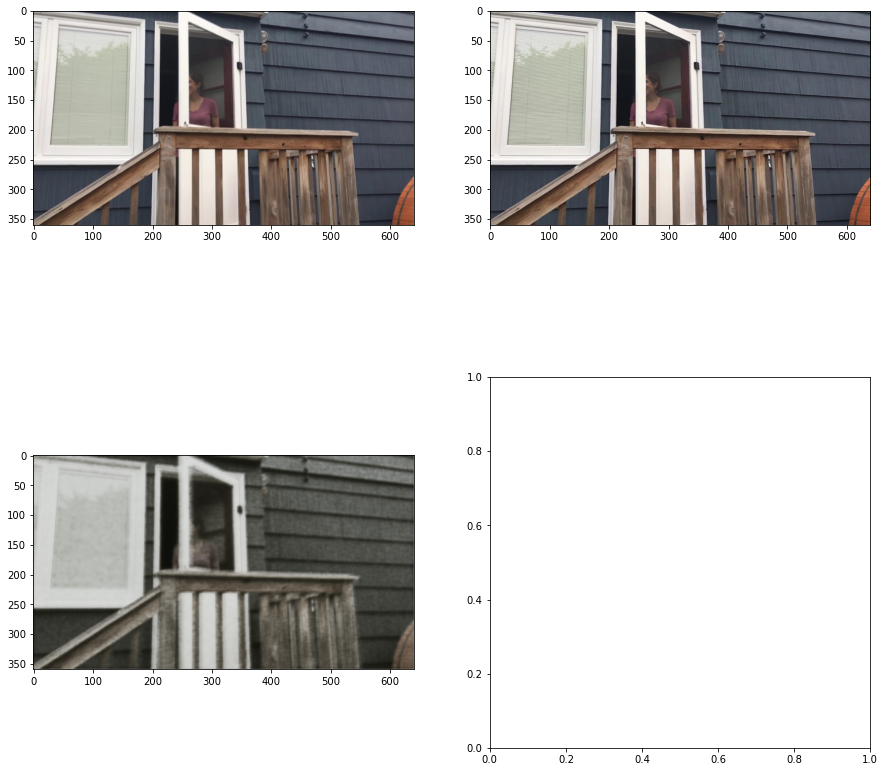

In [10]:
# Testing the results for a frame

plt.figure()
plt.rcParams['figure.figsize'] = [15, 15]

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(2,2)

i = 1

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0][0].imshow( reformatTensor2Image( x[i][2] ) )
axarr[0][1].imshow( reformatTensor2Image( y[i] ) )
axarr[1][0].imshow( reformatTensor2Image( ypred[i] ) )
#axarr[1][1].imshow( reformatTensor2Image( torch.mean(x[i], dim=2)[i] ) )

In [10]:
printDiagram(model, x, 'convLSTM.jpg')

C:\Users\Aman\AppData\Local\Temp\ipykernel_15340\1530343361.py:212: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  out = self.conv2(out) + temp[:, :, int(temp.shape[2]/2), :, :]
D:\Programs\mc3\lib\site-packages\torch\onnx\symbolic_opset9.py:1672: UserWarning: Dropout is a training op and should not be exported in inference mode. For inference, make sure to call eval() on the model and to export it with param training=False.
  warnings.warn("Dropout is a training op and should not be exported in inference mode. "
D:\Programs\mc3\lib\site-packages\torch\onnx\symbolic_helper.py:384: UserWarning: You are trying to export the model with onnx:Upsample for ONNX opset version 9. This operator might cause results to not match the expected results by PyTorch.
ONNX's Upsample/Res

In [17]:
# Prediction on test data
for dr in tq.tqdm( testInfo['dirname'] ):
    predict(model, testDirectory + dr + '/input', testDirectory + dr + '/convLSTM')

  0%|          | 0/19 [00:00<?, ?it/s]

In [ ]:
pipeLinePredictor(model, 'input.mp4', 'lstm.mp4')